In [ ]:
!git clone https://github.com/mjalali/embedding-comparison

In [ ]:
%cd embedding-comparison

# SPEC Feature Comparison Notebook

This notebook demonstrates how to compare embedding spaces across vision backbones using **SPEC** (Spectral Embedding Comparison).  
We will:

1. Load precomputed features for different models.  
2. Prepare an image dataset.  
3. Run SPEC on two models of choice.  
4. Visualize eigenvalues and modes.  


In [ ]:
%cd spec

In [3]:
# Imports 
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from glob import glob


from datasets.ImageFilesDataset import ImageFilesDataset
from spec_core import SPEC
from utils import visualize_modes_covariance, gaussian_covariance


## Loading the feature embeddings

You can use `spec/extract_features.py` to extract the features

Here is an example of how to run `extract_features.py`

```bash
python extract_features.py --img_path path-to-image-directory --batch_size 64 --feat_extractor dino --output dino_features.npz

```

In [ ]:
# In case you want to use `extract_features.py`
!python extract_features.py --img_path path-to-image-dir --batch_size 64 --feat_extractor dino --output dino_features.npz --extension png


In [ ]:
!python extract_features.py --img_path path-to-image-dir --batch_size 64 --feat_extractor clip --output clip_features.npz --extension png

In [8]:
#  Load Precomputed Features
# Update file paths to where your .npz features are stored

dino = np.load('dino_features.npz')['features']
clip = np.load('clip_features.npz')['features']


## Loading the dataset

In [10]:
# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    # You can normalize if required by your features
])

If you want to pass the images paths in a list:

In [ ]:
# === Load Image Paths ===
# Provide the folder containing images (.png or .jpg)

image_paths = sorted(glob('path-to-images/*.png'))  # change to 'images/*.jpg' if needed
print(f"Found {len(image_paths)} images.")

# === Dataset ===
dataset = ImageFilesDataset(
    path='',
    name='dataset-name',          # arbitrary label
    path_files=image_paths,
    transform=transform,
    extension='png'
)

Or you can provide a directory of images:

In [ ]:

dataset = ImageFilesDataset(
    path='path-to-image-dir',
    name='dataset-name',          # arbitrary label
    transform=transform,
    extension='png'
)

In [27]:
# === Prepare Models Dictionary ===
models = {
    'dino': (dino, 'dino', 28),
    'clip': (clip, 'clip', 3.5),
    # 'swav': (swav, 'swav', 0.9),
    # 'inception': (inception, 'inception', 7.3)
}


In [28]:
# === Choose Two Models to Compare ===
x, x_name, x_sigma = models['dino']
y, y_name, y_sigma = models['clip']

print(f"Comparing {x_name} vs {y_name}")


Comparing dino vs clip


## Loading SPEC

In [14]:
# === SPEC Setup ===
spec = SPEC(sigma=0)
method = 'cholesky'   # or 'direct', cholesky is recommended
rff = 3000


In [29]:
# === Compute Gaussian Covariance ===
cov_x, _, x_feature = gaussian_covariance(
    torch.from_numpy(x).float(),
    rff_dim=rff, batchsize=64, sigma=x_sigma, return_features=True
)

cov_y, _, y_feature = gaussian_covariance(
    torch.from_numpy(y).float(),
    rff_dim=rff, batchsize=64, sigma=y_sigma, return_features=True
)

# del cov_x, cov_y

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


### Checking if the kernel bandwidthes are proper

1. The eigenvalues should be well seperated
2. The maximum eigenvalue of each should be close to each other

0.13570784


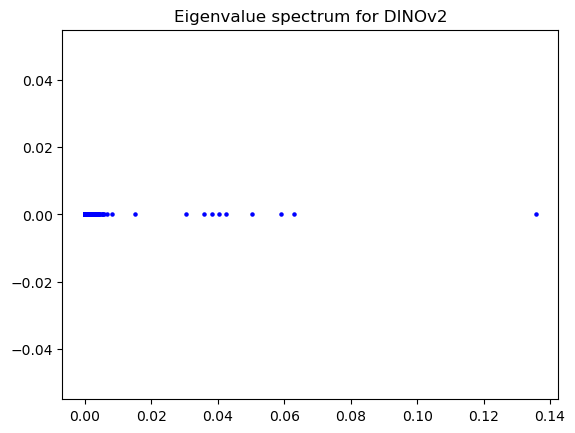

In [30]:
eig = torch.linalg.eigvals(cov_x)
vals = eig.real.cpu().numpy()
plt.title('Eigenvalue spectrum for DINOv2')
plt.scatter(vals, [0] * vals.shape[0], s=5, c='blue')
print(np.max(vals))

0.15749645


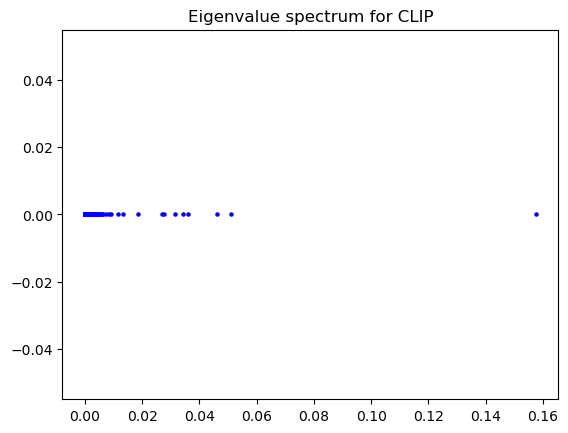

In [31]:
eig = torch.linalg.eigvals(cov_y)
vals = eig.real.cpu().numpy()
plt.title('Eigenvalue spectrum for CLIP')
plt.scatter(vals, [0] * vals.shape[0], s=5, c='blue')
print(np.max(vals))

## SPEC Eigendecomposition

In [33]:
import time
start_time = time.time()

eigenvalues, eigenvectors = spec.compute_by_covariance_matrix(
    x=x, y=y,
    cov_function=None,
    phi_x=x_feature, phi_y=y_feature,
    eta=1, method=method
)

elapsed_time = time.time() - start_time
print(f"SPEC computation took {elapsed_time:.4f} seconds")


SPEC computation took 2.6689 seconds


## Visualization

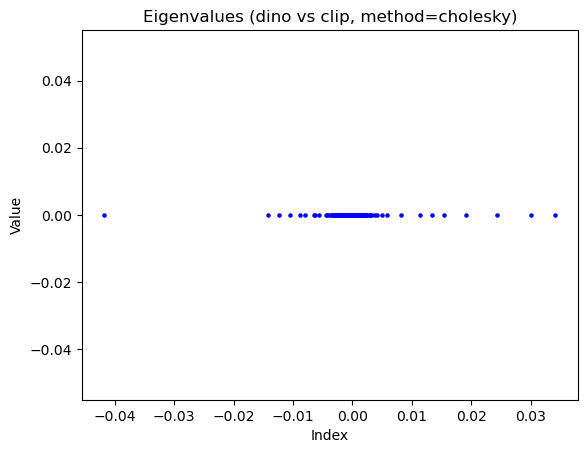

In [34]:
# === Plot Eigenvalues ===
plt.scatter(eigenvalues.real.cpu(), [0]*eigenvalues.shape[0], s=5, c='blue')
plt.title(f"Eigenvalues ({x_name} vs {y_name}, method={method})")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()


6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
6000, 6000
Using UMAP


/home/student/miniconda3/envs/aist5020/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/student/miniconda3/envs/aist5020/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/student/miniconda3/envs/aist5020/lib/python3.9/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/student/miniconda3/envs/aist5020/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


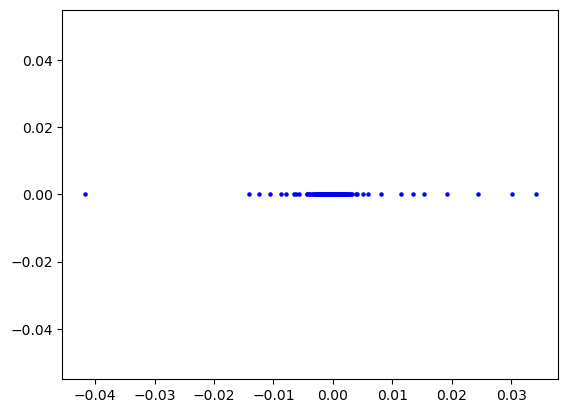

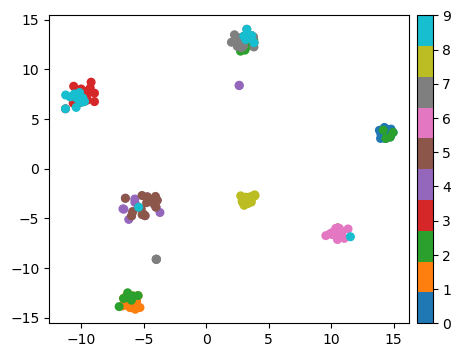

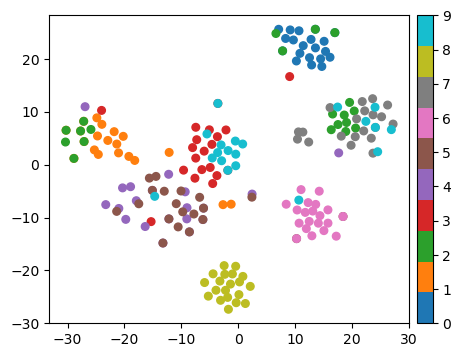

In [37]:
# === Visualize Modes ===
indexes = visualize_modes_covariance(
    eigenvalues, eigenvectors,
    x_feature=x_feature, y_feature=y_feature,
    num_visual_mode=10,
    save_dir=f'visualize_clusters/{x_name}-{y_name}-{method}',
    dataset=dataset,
    save_file=True,
    num_samples_per_mode=20,
    x=x, y=y,
    model_names=(x_name.upper(), y_name.upper())
)
